In [4]:
#Importowanie bibliotek
from __future__ import absolute_import, division, print_function, unicode_literals

 

import re
import skimage
import tensorflow as tf


from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.normalization import BatchNormalization, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence

from scipy import misc, ndimage  
from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage import data, io, filters, exposure, feature,img_as_float, img_as_ubyte
from skimage.io import imread#,Image
from skimage.transform import resize
from skimage.filters import threshold_otsu, sobel, rank
from skimage.filters.edges import convolve
from skimage.util.dtype import convert
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#from matplotlib import pylab as pl
import PIL

from numpy import array

from IPython.display import display
from ipywidgets import interact, interactive, fixed
from IPython.core.display import clear_output
#from os import listdir
#from os.path import join

import warnings
warnings.simplefilter("ignore")


%matplotlib inline 

In [6]:
#przygotowanie danych w pamięci

def przygotujDane(cwd = os.getcwd()):

    train_dir = cwd + '/dane/train'
    dest_dir = cwd +'/dane/all'
    counter = 0

    for subdir, dirs, files in os.walk(train_dir):
        #print(dirs)
        #print(subdir)
        #print(files[0])
        for file in files:
            full_path = os.path.join(subdir, file)
            shutil.copy(full_path, dest_dir)
            counter = counter + 1
    #print(counter)

    subdirs, dirs, files = os.walk(dest_dir).__next__()
    m = len(files)
    #print(m)
    #print(dirs)
    #print(subdir)
    #print(files[0])

    filenames = []
    labels = np.zeros((m, 1))


    images_dir = dest_dir
    filenames_counter = 0
    labels_counter = -1

    for subdir, dirs, files in os.walk(train_dir):
        #print(dirs)
        #print(subdir)
        #print(files[0])
        for file in files:
            filenames.append(file)
            labels[filenames_counter, 0] = labels_counter
            filenames_counter = filenames_counter + 1
        labels_counter = labels_counter+1

    #print(len(filenames))
    #print(labels.shape)
    #print(labels[0],labels[200],labels[400])

    # saving the filename array as .npy file
    np.save('filenames.npy', filenames)


    # One hot vector representation of labels
    y_labels_one_hot = to_categorical(labels)

    # saving the y_labels_one_hot array as a .npy file
    np.save('y_labels_one_hot.npy', y_labels_one_hot)

    filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

    # saving the shuffled file.
    # you can load them later using np.load().
    np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
    np.save('filenames_shuffled.npy', filenames_shuffled)

    filenames_shuffled_numpy = np.array(filenames_shuffled)

    X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
        filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.15, random_state=1)

    #print(X_train_filenames.shape) # (,)
    #print(y_train.shape)           # (, 4)
    total_train=X_train_filenames.shape[0]

    #print(X_val_filenames.shape)   # (,)
    #print(y_val.shape)             # (, 4)
    total_val=X_val_filenames.shape[0] 
    #print("próbek:", total_train, total_val)

    # You can save these files as well. As you will be using them later for training and validation of your model.
    np.save('X_train_filenames.npy', X_train_filenames)
    np.save('y_train.npy', y_train)

    np.save('X_val_filenames.npy', X_val_filenames)
    np.save('y_val.npy', y_val)
    
    return (total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir)

total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir = przygotujDane()

In [7]:
#generator do danych
class My_Custom_Generator(tf.keras.utils.Sequence):
    
    
    
    def __init__(self, image_filenames, labels, batch_size, images_dir, IMG_SIZE) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.images_dir = images_dir
        self.IMG_SIZE = IMG_SIZE
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
        return np.array([
            resize(imread(os.path.join(images_dir, str(file_name))), (self.IMG_SIZE, self.IMG_SIZE, 3))
               for file_name in batch_x])/255.0, np.array(batch_y)

In [8]:
#przygotowanie modelu sieci

def przygotujModel(batch_size = 32, IMG_SIZE = 126, 
                   X_train_filenames=X_train_filenames, y_train=y_train, 
                   X_val_filenames=X_val_filenames, y_val=y_val, images_dir=images_dir):
    
    
    my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size, images_dir, IMG_SIZE)
    my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size, images_dir, IMG_SIZE)
    #label_map = (my_training_batch_generator.class_indices)
   
    model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), activation ='relu',kernel_regularizer=regularizers.l2(0.001), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters = 126, kernel_size = (5,5), activation ='relu',kernel_regularizer=regularizers.l2(0.001), padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(axis=3),
    Dropout(0.3),
    
    
    
    Conv2D(filters = 126, kernel_size = (5,5), activation ='relu',kernel_regularizer=regularizers.l2(0.001), padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(axis=3),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return (model, my_training_batch_generator, my_validation_batch_generator)



#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

model, my_training_batch_generator, my_validation_batch_generator = przygotujModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 126)     100926    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 126)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 126)       504       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 126)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 126)       397026    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 126)       0

In [9]:
#trenowanie

def trenuj(epochs = 10, model = model, batch_size=32,
          my_training_batch_generator=my_training_batch_generator,
          my_validation_batch_generator=my_validation_batch_generator): 
    
    history = model.fit_generator(generator=my_training_batch_generator,
                       steps_per_epoch = int(total_train// batch_size),
                       epochs = epochs,
                       verbose = 1,
                       validation_data = my_validation_batch_generator,
                       validation_steps = int(total_val// batch_size)
                                 )
    return model

#model=trenuj(epochs=1)

In [10]:
#Podsumowanie wyników
def podsumowanie(epochs = 10, model = model):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [27]:
#przygotowanie sieci
def przygotujSiec(trening):
        
    model=[]
    #trening=1
    if os.path.exists(os.path.join(os.getcwd(), "model.json")) and trening==0:
        json_file = open('model.json', 'r');        loaded_model_json = json_file.read();        json_file.close();        loaded_model = model_from_json(loaded_model_json)
        #load weights into new model
        loaded_model.load_weights("model.h5");        model = loaded_model
        i=0
    else:
        total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir = przygotujDane(os.getcwd())

        model, my_training_batch_generator, my_validation_batch_generator = przygotujModel()

        model = trenuj(epochs=40)

        model_json = model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model.h5")

        
        
    return model


In [15]:
#obsługa obrazu
def imageInfo(image):
    width = len(image[0])
    height = len(image)
    return (width, height)

def wczytajObraz(dane):
    path = os.path.join(os.getcwd(), "input", dane)
             
    return img_as_float(io.imread(path))
    

def podziel(obraz):
    image = obraz 
    #dividing image on horizontal stripes:
    white = np.array([1, 1, 1])
    horizontal = []
    previousLineIsBorder = True
    start = 0
    end = 0
    width, height = imageInfo(image)
    outlineCoordsHorizontal = []
    outlineCoords = []
    for i in range(0, height - 1):
        allWhite = True
        for j in range(0, width - 1):
            if sum(np.abs(image[i][j] - white)) >= 0.3:
                allWhite = False
        if allWhite == False and previousLineIsBorder == True:
            previousLineIsBorder = False
            start = i
        if allWhite == True and previousLineIsBorder == False:
            previousLineIsBorder = True
            end = i
            horizontal.append(image[start:end, 0:width])
            outlineCoordsHorizontal.append(start)
       
    #extracting individual pictures from stripes:
    pictures = []
    stripeNr = 0
    for stripe in horizontal:
        previousLineIsBorder = True
        start = 0
        end = 0
        height = len(stripe)
        width = len(stripe[0])
        #print(width, height)
        #print(stripe.shape)
        for i in range(0, width - 1):
            allWhite = True
            for j in range(0, height - 1):
                if sum(np.abs(stripe[j][i] - white)) >= 0.3:
                    allWhite = False
            if allWhite == False and previousLineIsBorder == True:
                previousLineIsBorder = False
                start = i
            if allWhite == True and previousLineIsBorder == False:
                previousLineIsBorder = True
                end = i
                pictures.append(stripe[0:height, start:end])
                if stripeNr >= 0:
                    outlineCoords.append([outlineCoordsHorizontal[stripeNr], start, outlineCoordsHorizontal[stripeNr] + height, end])
        stripeNr += 1
                
    return pictures, outlineCoords
    


#rozdzielone
def displayPictures(pictures): 
    for pic in pictures:
        plt.imshow(pic)
        #print(pic.shape)
        plt.show()
   
    plt.imshow(out)
    plt.show()

def splitter(string):
    raw = r'{}'.format(string)
    return raw.replace("\\", "/").split("/")
#nierozdzielone
#def displayImage(path): 
#    image = img_as_float(io.imread(path)
#    plt.imshow(image)
#    plt.show()

def zaznacz(koordy, obraz, IMG_SIZE, wybrane=[[1, 0, 1], [0, 1, 0], [1, 0, 1]]):
    grLini = 9
    for i in range(3):
        for j in range(3):
            if wybrane[i][j] == 1:
                startY = koordy[3 * i + j][1]
                startX = koordy[3 * i + j][0]
                endY = koordy[3 * i + j][3]
                endX = koordy[3 * i + j][2]
                for x in range(startX, endX):
                    for y in range(startY, endY):
                        if x - startX < grLini or endX - x < grLini or y - startY < grLini or endY - y < grLini:
                            obraz[x][y] = [0.7, 0.1, 0.1]
               
    plt.imshow(obraz)
    plt.show()
    return obraz

Starting program... ...


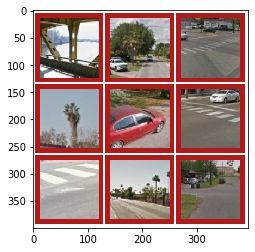

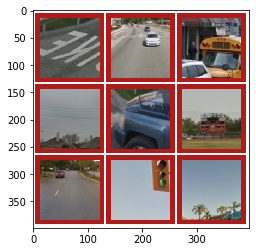

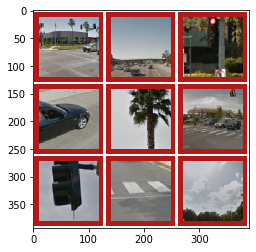

[9, 9, 9]
Finishing program...


In [34]:
#właściwa część programu

def main():
    print("Starting program... ...")

    #parametry
    nazwy = ["test1.jpg", "test2.jpg", "test3.jpg"]
    szukane = 'zebra'
    IMG_SIZE = 126
    trening = 0
    
  
    #działanie sieci
    model = przygotujSiec(trening)
    
    class_names = glob("dane/train/*") # Reads all the folders in which images are present
    class_names = sorted(class_names) # Sorting them
    
    lista=[]
    wykrytych=[]
    for nazwa in nazwy:
        
        #cała grafika
        captcha = wczytajObraz(nazwa)
        
        #lista grafik składowych, koordynaty obrazów
        obrazy, koordy = podziel(captcha)


        predykcje=[]
        for obraz in obrazy:
            pred = model.predict_classes(obraz.reshape([1,126,126,3]))[0]
            predykcje.append(splitter(class_names[pred])[2])


        #predykcje[1]='zebra'

        #ustawianie odpowiedzi na pytanie, czy wykryta klasa jest zgodna z szukaną i zliczanie sukcesów
        sukcesy=0
        for i in range(len(predykcje)):
            if predykcje[i]==szukane:
                predykcje[i]=1
            else:
                predykcje[i]=0
            sukcesy+=predykcje[i]
                
 
        siatka = []
        for i in range(3):
            siatka.append([])
            for j in range(3):
                siatka[i].append(predykcje[3*i+j])

        #print(predykcje)
        #print(siatka)
        #Wyświetlanie wyników
        gotowy=zaznacz(koordy, captcha, IMG_SIZE, wybrane=siatka)
        lista.append(gotowy)
        wykrytych.append(sukcesy)
        
    #displayPictures(lista)
    
   

                
                
    print(wykrytych)
 
    print("Finishing program...")

main ()
